# **MODEL VALIDATION**
### This class make prediction using another set of images to validate the efficacy of the model

## **Initialize Parameter**

In [1]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

root_directory = 'drone/'
root_directory2 = 'Semantic segmentation dataset/'

patch_size = 256

## **Image Preproccessing**

### **Load Images 1 (Own Source)**

In [2]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(files)  
    dirname = path.split(os.path.sep)[-1]
    
    images = os.listdir(path)  #List of all image names in this subdirectory
    for i, image_name in enumerate(images):  
        if image_name.endswith(".JPG"):   #Only read jpg images...
               
            #print(image_name)
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
       
            #Extract patches from each image
            print("Now patchifying image:", path+""+image_name)
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                        
                    single_patch_img = patches_img[i,j,:,:]
                        
                    #Use minmaxscaler instead of just dividing by 255. 
                    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    image_dataset.append(single_patch_img)

Now patchifying image: drone/0001.JPG
Now patchifying image: drone/0002.JPG
Now patchifying image: drone/0003.JPG


### **Load Images 2 (From Kaggle Dataset)**

In [2]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory2):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_004.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_005.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_006.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_007.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_008.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_009.jpg
Now patchifying image: Semantic segmentation dataset/Tile 2\images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 2\images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/T

## **Convert dataset to numpy**

In [3]:
# Convert dataset to numpy array 
image_dataset = np.array(image_dataset)

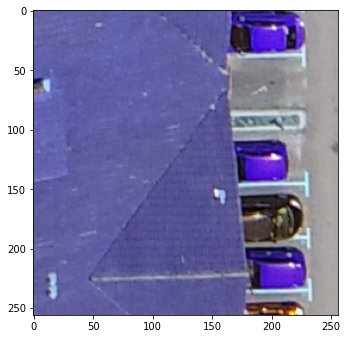

In [13]:
# Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))

## **Load Model**
Load trained model. Compile as false.

In [14]:
from keras.models import load_model
model = load_model("models/satellite_unet_100epochs_6Oct2021.hdf5",compile=False)

## **Make Prediction**
Using random image selection. Make next-to-next comparison between testing image and prediction on testing image

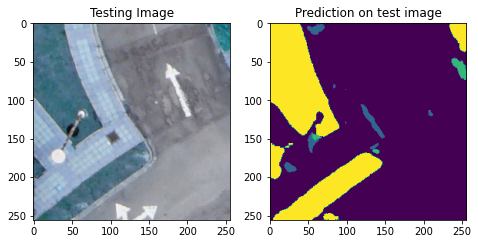

In [15]:
import random
test_img_number = random.randint(0, len(image_dataset))
test_img = image_dataset[test_img_number]

#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()